<a href="https://colab.research.google.com/github/keithth/AI_Apps/blob/main/Build_a_Custom_AI_Agent_with_Haystack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a Custom AI Agent with Haystack

*Notebook by [Bilge Yucel](https://www.linkedin.com/in/bilge-yucel/) for Code & Deploy. Watch the recording [here](https://www.linkedin.com/events/code-deploy-buildyourfirstgenai7226658275792932864/comments/)*

📚 Useful Resources
* [🌐 Website](https://haystack.deepset.ai/)
* [📘 Documentation](https://docs.haystack.deepset.ai/docs)
* [🧑‍🏫 Tutorials](https://haystack.deepset.ai/tutorials)
* [🧑‍🍳 Cookbooks](https://github.com/deepset-ai/haystack-cookbook)

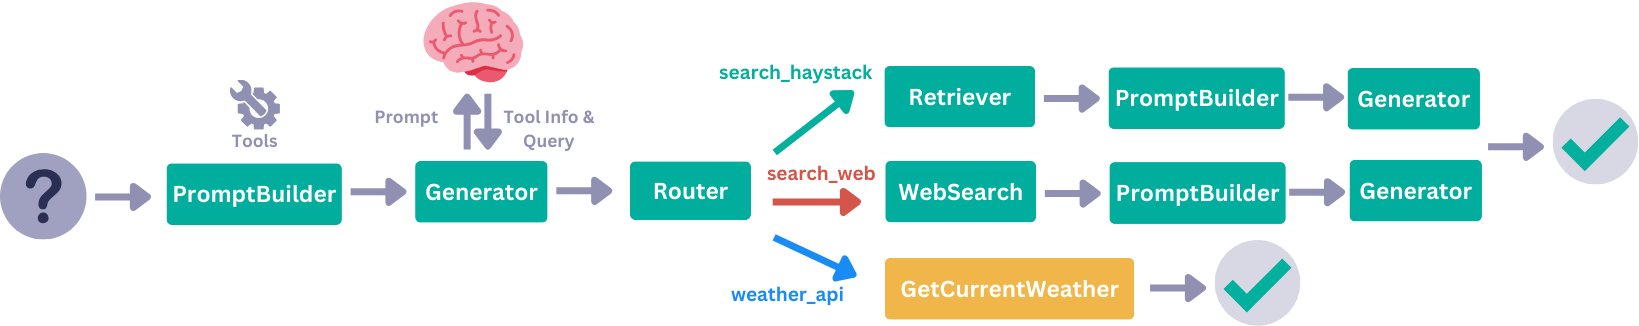

>[Build an AI Agent with Haystack](#scrollTo=oXOLE-gZ5Bz9)

>>[Tools ⚒️](#scrollTo=sj6RkPEd9Qyr)

>>>[Indexing for RAG](#scrollTo=CLcmK85e96hL)

>>[RAG](#scrollTo=mnOh6_0A-USp)

>>[Web Search](#scrollTo=Jcql4NR8AveC)

>>[Weather API](#scrollTo=uNS-oa_0CX-i)

>>[Router](#scrollTo=nXpKuSz8B10i)

>>[Agent 🤖](#scrollTo=YWP5qKNbExoj)

>>[Live Demo](#scrollTo=C3Q5Ji1QRyeP)



## Key & logs

In [18]:
import os
from google.colab import userdata

# Retrieve secrets directly from Colab's Secrets panel
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["Unstructured_API_key"] = userdata.get('Unstructured_API_key')
os.environ["SERPERDEV_API_KEY"] = userdata.get('SERPERDEV_API_KEY')
# os.environ["HF_API_TOKEN"] = userdata.get('HF_API_TOKEN')
# os.environ["weather_api_key"] = userdata.get('weather_api_key')

print("All API keys have been loaded from secrets.")


All API keys have been loaded from secrets.


In [2]:

import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [3]:
!pip install -qU haystack-ai
!pip install -qU trafilatura

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.9/837.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 23.0 MB/s eta 0:00:00


In [4]:
!pip show haystack-ai trafilatura | grep Version | cut -d: -f2

 2.10.3
 2.0.0


# import ChatMessage


In [5]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator

# Define the system message that includes the tool definitions
system_message = ChatMessage.from_system(
"""
You are a virtual assistant, equipped with the following tools:

"tools": [
  {
    "name": "search_web",
    "description": "Access to Google search, use this tool whenever information on recents events is needed",
    "parameters": {
      "type": "object",
      "properties": {
        "query": {
          "type": "string",
          "description": "query to search in web"
        }
      }
    }
  },
  {
    "name": "search_haystack",
    "description": "Access to Haystack documentation, use this tool whenever information on building with LLMs, custom AI applications, Haystack, the open source LLM framework, is needed",
    "parameters": {
      "type": "object",
      "properties": {
        "query": {
          "type": "string",
          "description": "query to search in the database"
        }
      }
    }
  }
]

Select the most appropriate tool to resolve the user's query. Respond in JSON format, specifying the user request, modified query and the chosen tool for the response.
If you can't match user query to an above listed tools, respond with `search_web`.

Here are some examples:

{
  "user_request": "Why did Elon Musk recently sue OpenAI?",
  "tool_name": "search_web",
  "query": "Why did Elon Musk recently sue OpenAI?"
}
{
  "user_request": "What are the init parameters of HuggingFaceAPIGenerator component?"
  "tool_name": "search_haystack"
  "query": "What are the init parameters of HuggingFaceAPIGenerator component?"
}

Choose the best tool (or none) for each user request and modify the query, considering the current context of the conversation specified above.

Here's the user_request: {{query}}
"""
)

# Define the user message with the query
user_message = ChatMessage.from_user(" Where, in the Gulf of Mexico, is The Fuji system?")

# Initialize the OpenAI Chat Generator with your desired model
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini")

INFO:haystack.telemetry._telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems in the [documentation page](https://docs.haystack.deepset.ai/docs/telemetry#how-can-i-opt-out). More information at [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry).


In [6]:
# Ensure that the system message content is a string
# Using the from_system class method to create ChatMessage object
system_msg = ChatMessage.from_system(system_message.text)

response = chat_generator.run(messages=[
    system_msg,
    user_message
])
print(response)


{'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='{\n  "user_request": "Where, in the Gulf of Mexico, is The Fuji system?",\n  "tool_name": "search_web",\n  "query": "Where is The Fuji system located in the Gulf of Mexico?"\n}')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 48, 'prompt_tokens': 404, 'total_tokens': 452, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}})]}


In [7]:
print(type(system_message.text))


<class 'str'>


## Tools ⚒️

* RAG Pipeline (Indexing + Query)
* Web Search
* Weather API (Custom component)

### Indexing for RAG

In [8]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter

document_store = InMemoryDocumentStore()

# Indexing pipeline

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(instance=LinkContentFetcher(), name="fetcher")
indexing_pipeline.add_component(instance=HTMLToDocument(), name="converter")
indexing_pipeline.add_component(instance=DocumentCleaner(), name="cleaner")
indexing_pipeline.add_component(instance=DocumentSplitter(split_by="word", split_length=512, split_overlap=50), name="splitter")
indexing_pipeline.add_component(instance=DocumentWriter(document_store = document_store), name="writer")

indexing_pipeline.connect("fetcher.streams", "converter.sources")
indexing_pipeline.connect("converter.documents", "cleaner")
indexing_pipeline.connect("cleaner", "splitter")
indexing_pipeline.connect("splitter", "writer.documents")

# index some documentation pages to use for RAG
indexing_pipeline.run({
    "fetcher": {
        "urls": ["https://drive.google.com/file/d/1Fl-orR32Fy5ZTtNptPcKAo9chpw7NgoE/view?usp=drive_link",
            "https://docs.haystack.deepset.ai/docs/intro",
            "https://docs.haystack.deepset.ai/docs/huggingfacelocalgenerator",
            "https://docs.haystack.deepset.ai/docs/huggingfacelocalchatgenerator",
            "https://docs.haystack.deepset.ai/reference/generators-api",
            "https://haystack.deepset.ai/overview/quick-start",
            "https://haystack.deepset.ai/overview/intro"
            ]}})

INFO:haystack.core.pipeline.base:Warming up component splitter...
INFO:haystack.core.pipeline.pipeline:Running component fetcher
INFO:haystack.core.pipeline.pipeline:Running component converter
INFO:haystack.core.pipeline.pipeline:Running component cleaner
INFO:haystack.core.pipeline.pipeline:Running component splitter
INFO:haystack.core.pipeline.pipeline:Running component writer


{'writer': {'documents_written': 18}}

## RAG

In [27]:
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage
from pprint import pprint

# RAG pipeline: initialize the retriever as before
retriever = InMemoryBM25Retriever(document_store=document_store)

# Define a prompt template suitable for OpenAI's Chat model.
# Notice that we removed the <s>[INST] and [/INST] tokens.
rag_prompt_template = """You are a virtual assistant. Answer the following query based on the documents provided below.

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}}
"""

# Create a prompt builder for the RAG task
prompt_builder_for_rag = PromptBuilder(template=rag_prompt_template,
                                       required_variables=["documents", "query"]
                                       )

# Instead of using HuggingFaceAPIGenerator, initialize the OpenAIChatGenerator.
llm_for_rag = OpenAIChatGenerator(model="gpt-4o-mini")

# Example usage:
# Suppose we build the prompt using the prompt builder:
# changed from build_prompt to run and combined the arguments into a single dict
prompt_text = prompt_builder_for_rag.run(
    documents=[{"content": "Example document content."}],
    query="What is Natural Language Processing?"
)
pprint(prompt_text)


{'prompt': 'You are a virtual assistant. Answer the following query based on '
           'the documents provided below.\n'
           '\n'
           'Documents:\n'
           '\n'
           '  Example document content.\n'
           '\n'
           '\n'
           'Query: What is Natural Language Processing?'}


In [10]:
# To generate a response with OpenAI, you need to convert the prompt text into a chat message format.
# Typically, you'll provide a system message with the prompt and a user message with the query.
system_message = ChatMessage.from_system(prompt_text)
user_message = ChatMessage.from_user("Please provide a concise answer.")


In [11]:
print(type(system_message.text))


<class 'dict'>


In [12]:
print(system_message.text.keys())


dict_keys(['prompt'])


In [13]:
plain_text = system_message.text.get("prompt", "")
print(plain_text)


You are a virtual assistant. Answer the following query based on the documents provided below.

Documents:

  Example document content.


Query: What is Natural Language Processing?


In [14]:
# plain_text = system_message.text["content"]


In [15]:
response = llm_for_rag.run(messages=[
    ChatMessage.from_system(system_message.text["prompt"]),
    user_message
])
pprint(response)

{'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on the interaction between computers and humans through natural language. It involves the ability of computers to understand, interpret, and generate human language in a meaningful way.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 47, 'prompt_tokens': 49, 'total_tokens': 96, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}})]}


## Web Search

In [26]:
from haystack.components.websearch.serper_dev import SerperDevWebSearch
from haystack.components.builders import PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator

# Web RAG pipeline using OpenAI

# Define a prompt template without special tokens for OpenAI
prompt_for_websearch = """You are a virtual assistant that answers the following query based on documents retrieved from the web.
Your answer should clearly indicate that it was generated from websearch.

Documents:
{% for document in documents %}
  {{ document.content }}
{% endfor %}

Query: {{ query }}"""

# Instantiate the web search component (remains unchanged)
websearch = SerperDevWebSearch()

# Create the prompt builder for websearch
prompt_builder_for_websearch = PromptBuilder(
    template=prompt_for_websearch,
    required_variables=["documents", "query"]
)

# Initialize the OpenAI Chat Generator with your desired model (e.g., "gpt-4" or "gpt-3.5-turbo")
llm_for_web = OpenAIChatGenerator(model="gpt-4o-mini")

# Example usage:
# Assume you have some documents retrieved by your websearch component and a query:
documents = [{"content": "Example web document content about recent AI research."}]
query = "What are the latest developments in AI research?"

# Build the prompt using the prompt builder
# Build the prompt using the prompt builder
built_prompt = prompt_builder_for_websearch.run(documents=documents, query=query)
# built_prompt = prompt_builder_for_websearch.build_prompt(
#     documents=documents,
#     query=query
#     )
print("Built Prompt:")
print(built_prompt)

# built_prompt = prompt_builder_for_websearch.build(documents=documents, query=query)
# print("Built Prompt:")
# print(built_prompt)

# For OpenAIChatGenerator, convert the built prompt into a system message and add a user message
from haystack.dataclasses import ChatMessage
system_message = ChatMessage.from_system(built_prompt)
user_message = ChatMessage.from_user("Please provide a concise answer.")

# Run the generator with the chat messages
response = llm_for_web.run(messages=[system_message, user_message])
print("Response:")
print(response)


Built Prompt:
{'prompt': 'You are a virtual assistant that answers the following query based on documents retrieved from the web.\nYour answer should clearly indicate that it was generated from websearch.\n\nDocuments:\n\n  Example web document content about recent AI research.\n\n\nQuery: What are the latest developments in AI research?'}


BadRequestError: Error code: 400 - {'error': {'message': "Invalid type for 'messages[0].content': expected one of a string or array of objects, but got an object instead.", 'type': 'invalid_request_error', 'param': 'messages[0].content', 'code': 'invalid_type'}}

In [25]:
print(type(system_message.text))

print(system_message.text.keys())

plain_text = system_message.text.get("prompt", "")
print(plain_text)


<class 'dict'>
dict_keys(['prompt'])
You are a virtual assistant that answers the following query based on documents retrieved from the web.
Your answer should clearly indicate that it was generated from websearch.

Documents:

  Example web document content about recent AI research.


Query: What are the latest developments in AI research?


In [16]:
from haystack.components.websearch.serper_dev import SerperDevWebSearch

# Web RAG pipeline

prompt_for_websearch = """ "<s>[INST]
Answer the following query given the documents retrieved from the web.
Your answer shoud indicate that your answer was generated from websearch.

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}} [/INST]
"""

websearch = SerperDevWebSearch()
prompt_builder_for_websearch = PromptBuilder(template=prompt_for_websearch, required_variables=["documents", "query"])
llm_for_web = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "mistralai/Mistral-7B-Instruct-v0.3"})

ValueError: None of the following authentication environment variables are set: ('SERPERDEV_API_KEY',)

## Weather API

Get your API key from [weatherapi.com](https://www.weatherapi.com/my/)

In [ ]:
# weather_api_key = getpass("WEATHER_API") c3db5bc8b0f34997812234126251602

In [ ]:
import requests
from haystack import component

# GetCurrentWeather
@component
class GetCurrentWeather:
  def __init__(self, api_key):
    self.api_key = api_key

  @component.output_types(text=str)
  def run(self, city:str):
    response = requests.get(f'https://api.weatherapi.com/v1/current.json?q={city}&key={self.api_key}').json()

    current_condition = response["current"]["condition"]["text"]
    current_temp = response["current"]["temp_c"]
    text = f'The weather in {city} is {current_condition} with {current_temp} degrees'

    return {"text": text}

## Router

In [ ]:
from haystack.components.routers import ConditionalRouter

# Router
main_routes = [
        {
        "condition": "{{'weather_api' in tool_name}}",
        "output": "{{query}}",
        "output_name": "weather_api",
        "output_type": str,
    },
    {
        "condition": "{{'search_haystack' in tool_name}}",
        "output": "{{query}}",
        "output_name": "search_haystack",
        "output_type": str,
    },
    {
        "condition": "{{'search_web' in tool_name}}",
        "output": "{{query}}",
        "output_name": "search_web",
        "output_type": str,
    },
]

tool_router = ConditionalRouter(main_routes)

### Connection Components

In [ ]:
from haystack import component
from typing import List
import json

## AnswerParser
@component
class AnswerParser:

  @component.output_types(tool_name=str, query=str)
  def run(self, replies:List[str]):
    reply = json.loads(replies[0])

    tool_name = reply["tool_name"]
    query = reply["query"]

    return {"tool_name": tool_name, "query":query}

## Agent 🤖


In [ ]:
weather_api_key = os.environ.get("weather_api_key")



In [ ]:


from haystack import Pipeline

agent = Pipeline()
agent.add_component("prompt_builder_for_agent", prompt_builder_for_agent)
agent.add_component("llm_for_agent", llm_for_agent)
agent.add_component("answer_parser", AnswerParser())
agent.add_component("tool_router", tool_router)

# web
agent.add_component("websearch", websearch)
agent.add_component("prompt_builder_for_websearch", prompt_builder_for_websearch)
agent.add_component("llm_for_web", llm_for_web)

# RAG
agent.add_component("retriever", retriever)
agent.add_component("prompt_builder_for_rag", prompt_builder_for_rag)
agent.add_component("llm_for_rag", llm_for_rag)

# Weather API
agent.add_component("get_weather", GetCurrentWeather(weather_api_key))
agent.connect("prompt_builder_for_agent", "llm_for_agent")
agent.connect("llm_for_agent","answer_parser")
agent.connect("answer_parser.query", "tool_router.query")
agent.connect("answer_parser.tool_name", "tool_router.tool_name")

# Web Search
agent.connect("tool_router.search_web", "websearch.query")
agent.connect("tool_router.search_web", "prompt_builder_for_websearch.query")
agent.connect("websearch.documents", "prompt_builder_for_websearch.documents")
agent.connect("prompt_builder_for_websearch", "llm_for_web")

# RAG
agent.connect("tool_router.search_haystack", "retriever.query")
agent.connect("tool_router.search_haystack", "prompt_builder_for_rag.query")
agent.connect("retriever.documents", "prompt_builder_for_rag.documents")
agent.connect("prompt_builder_for_rag", "llm_for_rag")

# Weather API
agent.connect("tool_router.weather_api", "get_weather")

In [ ]:
agent.show()

In [ ]:
query = "Can you tell me why cats purr?"
agent.run({"prompt_builder_for_agent": {"query": query}}, include_outputs_from={"llm_for_agent"})

## Live Demo

In [ ]:
!pip install -q --upgrade gradio

In [ ]:
import gradio as gr

def chatbot(message, history):
    response = agent.run({"prompt_builder_for_agent": {"query": message}}, include_outputs_from={"tool_router", "answer_parser"})
    answer = ""

    if "llm_for_web" in response.keys():
      answer = response["llm_for_web"]["replies"][0]
    elif "llm_for_rag" in response.keys():
      answer = response["llm_for_rag"]["replies"][0]
    else:
      answer = response["get_weather"]["text"]

    return answer


demo = gr.ChatInterface(
    fn=chatbot,
    examples=[
        "What's Einstein's first name?",
        "How is the weather in Toronto?",
        "Why do cats purr?",
        "What is Haystack?"
    ],
    title="Ask me about anything!",
)

In [ ]:
demo.launch()